# Risk Parity Investment Strategy
## Use Index of representative asset classes
#### Developed-Emerging Equity, Real Estate, Commmodity, Treasury, Corporate Bond, TIPS are included
### Resuld is driven from 2010 to 2021 market data

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import os
os.chdir(os.path.join('/mnt','c','workspace','project_quant'))
os.getcwd()

'/mnt/c/workspace/project_quant'

In [3]:
import os
import math
import numpy as np
import pandas as pd
import quantstats
from scipy.optimize import minimize

from utils.index_data import index_data
from utils.yahoo_stock_data import yahoo_data
from utils.regular_rebalancing import rp_rebalance_strategy

import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (12, 8) # (width, height)

#### Load Data of each asset classes
#### Data should be in yld format [rows : Dates, Columns : Asset Classes, yld = log(currnet_period_price/previous_period_price]

In [4]:
data_setting = {
    'start' : '2010-01-01',
    'end' : '2021-06-30',
    'rebal_period':'1M'
}

data = index_data(**data_setting)
yield_df = data.index_data_loading()

bm_class_ticker =[
    "IVV", # Vanguard Total Stock Market ETF                        2001-05-24
    "AGG", # iShares Core U.S. Aggregate Bond ETF                   2003-09-22
                    ]
# to draw benchmark
data_setting = {
    'start' : '2010-01-01',
    'end' : '2021-06-30',
    'ticker_list': bm_class_ticker,
    'rebal_period' : '1M',
}

# data = yahoo_data(**data_setting)
benchmark_yield_df = yield_df[['msci_acwi','bb_world_agg']]


In [5]:
def _60_40_strategy(yld_df):
    weights = pd.DataFrame(columns=yld_df.columns, index=yld_df.index)

    weights.loc[:,'msci_acwi'] = 0.600
    weights.loc[:,'bb_world_agg'] = 0.400
    # weights.loc[:,'VTI'] = 0.300
    # weights.loc[:,'TLT'] = 0.400
    # weights.loc[:,'IEI'] = 0.150
    # weights.loc[:,'GLD'] = 0.075
    # weights.loc[:,'GSG'] = 0.075
    return weights

In [6]:
def RiskParity(covariance_matrix) :
    """
    to calculate r
    :param covariance_matrix: covariance matrix of assets in universe
    :return: [list] weight of risk parity investment strategy
    """
    x0 = np.repeat(1/covariance_matrix.shape[1], covariance_matrix.shape[1])
    constraints = ({'type': 'eq', 'fun': SumConstraint},
                  {'type': 'ineq', 'fun': LongOnly})
    options = {'ftol': 1e-20, 'maxiter': 2000}

    result = minimize(fun = RiskParityObjective,
                      args = (covariance_matrix),
                      x0 = x0,
                      method = 'SLSQP',
                      constraints = constraints,
                      options = options)
    return result.x

def RiskParityObjective(x, covariance_matrix) :
    # x means weight of portfolio
    variance = (x.T) @ (covariance_matrix) @ (x)
    sigma = np.sqrt(variance)
    mrc = 1/sigma * (covariance_matrix @ x)
    risk_contribution = x * mrc
    a = np.reshape(risk_contribution.to_numpy(), (len(risk_contribution), 1))

    # set marginal risk level of asset classes equal
    risk_diffs = a - a.T
    # np.ravel: convert n-dim to 1-dim
    sum_risk_diffs_squared = np.sum(np.square(np.ravel(risk_diffs)))
    return (sum_risk_diffs_squared)

# constraint 1 : sum of weight should be less than equal to 1
def SumConstraint(weight):
    return (weight.sum()-1.0)

# constraint 2 : long only portfolio should be consists of postive weight vectors
def LongOnly(weight):
    return(weight)

def RiskContribution(weight, covariance_matrix) :
    """
    to check whether given portfolio is equally distributed
    :param weight: asset allocation weight of portfolio
    :param covariance_matrix:
    :return: risk contribution of each asset
    """
    weight = np.array(weight)
    variance = np.dot(np.dot(weight.T, covariance_matrix) ,weight)
    sigma = np.sqrt(variance)
    mrc = 1/sigma * np.dot(covariance_matrix, weight)

    risk_contribution = weight * mrc
    risk_contribution = risk_contribution / risk_contribution.sum()
    return risk_contribution

# Risk parity strategy Result
## 12 month market data driven investment strategy
## from 2002 to 2021 follwoing asset classes (index) are used to backtest

#### use previous 12 month market data for risk parity portfolio calcuation
#### rebalance monthly (beginning of month)
#### developed equity, emerging equity, real estate, infrastructure, metal, oil
#### short term bond, long term bond, investment grade corp bond, high yield corp bond, TIPS

In [7]:
month_rebal_strategy = rp_rebalance_strategy(
                                          strategy= RiskParity, yld_df=yield_df,
                                          bm_strategy=_60_40_strategy, bm_yld_df=benchmark_yield_df,
                                          lookback_period=12
                                          )
month_rebal_strategy

,strategy_return,benchmark_return,msci_acwi,msci_world,msci_emerging,msci_world_gross,msci_world_value,msci_real_estate,bb_world_agg,bb_emerging_agg,bb_corp_ig,bb_corp_hy,bb_infla_protect,snp_commodity,us_short_treasury,SUM
2011-01-31,0.003943,0.033196,0.013307,0.013539,0.011998,0.014118,0.012991,0.011793,0.221705,0.032096,0.078534,0.031769,0.06605,0.013051,0.479049,1.0
2011-02-28,0.003445,0.014516,0.01366,0.013932,0.012161,0.014486,0.013405,0.012141,0.219778,0.032523,0.07938,0.032532,0.067048,0.013579,0.475375,1.0
2011-03-31,0.004918,0.004967,0.0137,0.013974,0.012191,0.014512,0.01346,0.012153,0.219841,0.032552,0.079539,0.032699,0.068133,0.013583,0.473662,1.0
2011-04-30,0.002087,0.005339,0.014413,0.014593,0.013406,0.015154,0.014057,0.012576,0.221036,0.035216,0.081315,0.034102,0.071141,0.014264,0.458726,1.0
2011-05-31,0.013147,0.026235,0.015107,0.015205,0.014551,0.015731,0.014698,0.013421,0.216607,0.039183,0.085295,0.038116,0.073587,0.015362,0.443136,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-02-28,0.00078,0.003342,0.008818,0.00868,0.009926,0.008804,0.008585,0.00852,0.110133,0.017363,0.023566,0.015316,0.084346,0.007353,0.68859,1.0
2021-03-31,-0.002156,0.009891,0.008115,0.008016,0.008928,0.007931,0.008133,0.007964,0.095592,0.015986,0.021451,0.014246,0.068784,0.007192,0.727661,1.0
2021-04-30,0.000506,0.005897,0.017433,0.016971,0.021849,0.014206,0.021628,0.025721,0.110501,0.039561,0.04575,0.038447,0.093294,0.032447,0.522192,1.0
2021-05-31,0.007675,0.022185,0.015157,0.014713,0.019499,0.012276,0.018705,0.025728,0.094005,0.029463,0.044125,0.032775,0.068762,0.012962,0.611831,1.0


findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.


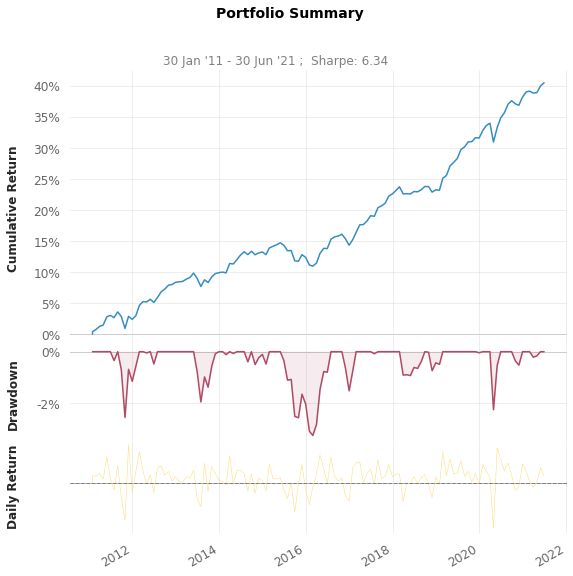

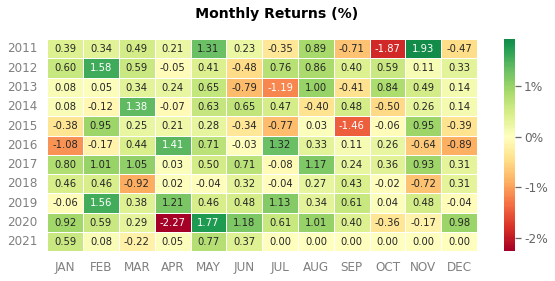

In [9]:
quantstats.reports.plots(month_rebal_strategy['strategy_return'], mode='basic')

In [10]:
quantstats.reports.metrics(returns=month_rebal_strategy['strategy_return'], benchmark=month_rebal_strategy['benchmark_return'],mode='full')

                           Strategy    Benchmark
-------------------------  ----------  -----------
Start Period               2011-01-31  2011-01-31
End Period                 2021-06-30  2021-06-30
Risk-Free Rate             0.0%        0.0%
Time in Market             100.0%      100.0%

Cumulative Return          40.47%      94.2%
CAGR﹪                     3.32%       6.58%

Sharpe                     6.37        3.41
Smart Sharpe               6.05        3.24
Sortino                    10.99       5.05
Smart Sortino              10.44       4.81
Sortino/√2                 7.77        3.57
Smart Sortino/√2           7.39        3.4
Omega                      2.85        2.85

Max Drawdown               -3.28%      -14.22%
Longest DD Days            397         609
Volatility (ann.)          10.78%      41.57%
R^2                        0.66        0.66
Calmar                     1.01        0.46
Skew                       -0.63       -0.91
Kurtosis                   1.71        4.3

                           Strategy    Benchmark
-------------------------  ----------  -----------
Start Period               2011-01-31  2011-01-31
End Period                 2021-06-30  2021-06-30
Risk-Free Rate             0.0%        0.0%
Time in Market             100.0%      100.0%

Cumulative Return          40.47%      94.2%
CAGR﹪                     3.32%       6.58%

Sharpe                     6.37        3.41
Smart Sharpe               6.05        3.24
Sortino                    10.99       5.05
Smart Sortino              10.44       4.81
Sortino/√2                 7.77        3.57
Smart Sortino/√2           7.39        3.4
Omega                      2.85        2.85

Max Drawdown               -3.28%      -14.22%
Longest DD Days            397         609
Volatility (ann.)          10.78%      41.57%
R^2                        0.66        0.66
Calmar                     1.01        0.46
Skew                       -0.63       -0.91
Kurtosis                   1.71        4.3

None

,Start,Valley,End,Days,Max Drawdown,99% Max Drawdown
1,2015-06-30,2016-02-29,2016-07-31,397,-3.277616,-3.110414
2,2011-09-30,2011-10-31,2012-02-29,152,-2.572537,-1.158643
3,2020-04-30,2020-04-30,2020-06-30,61,-2.270578,-0.537313
4,2013-06-30,2013-07-31,2013-12-31,184,-1.963948,-1.391037
5,2016-11-30,2016-12-31,2017-02-28,90,-1.531985,-0.741051


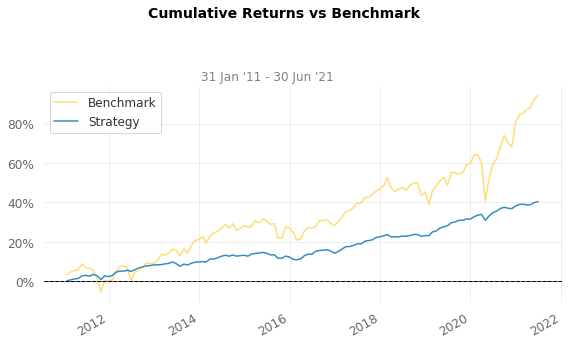

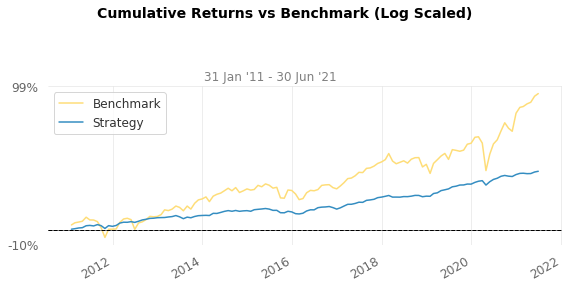

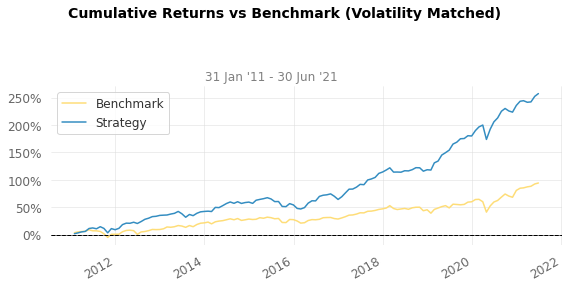

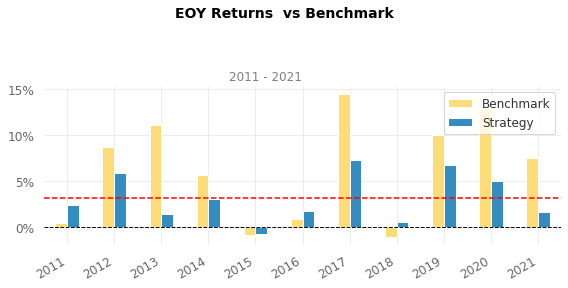

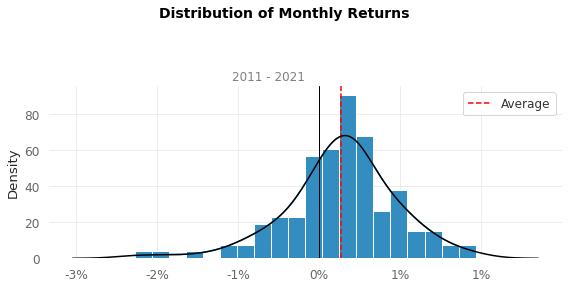

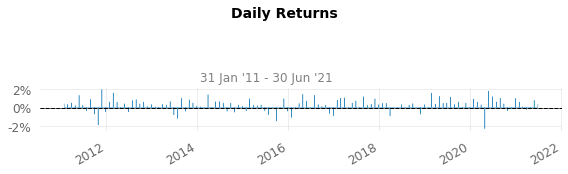

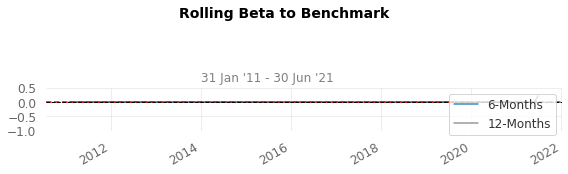

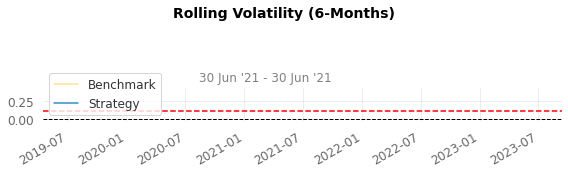

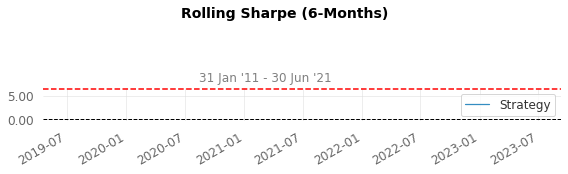

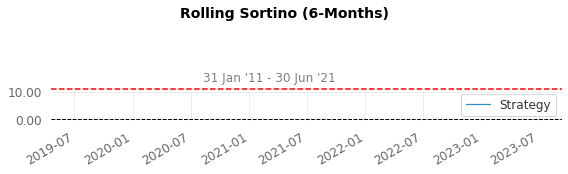

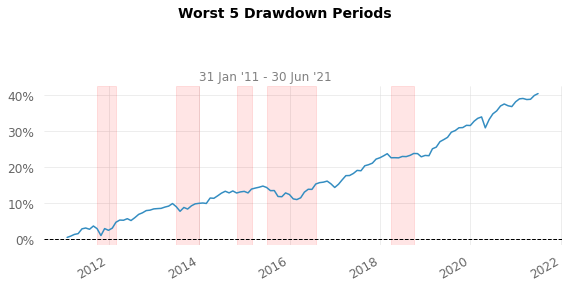

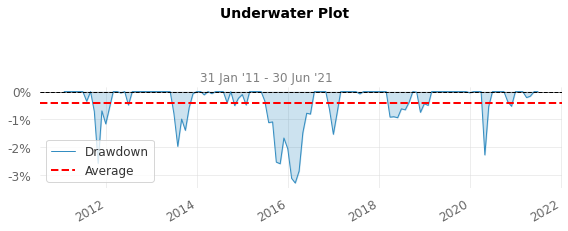

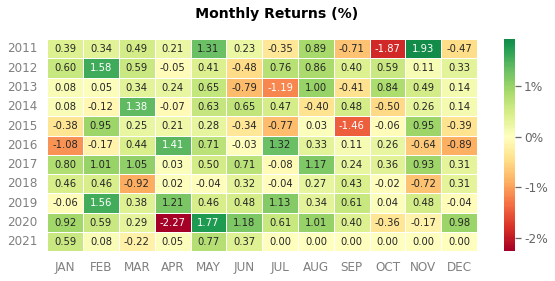

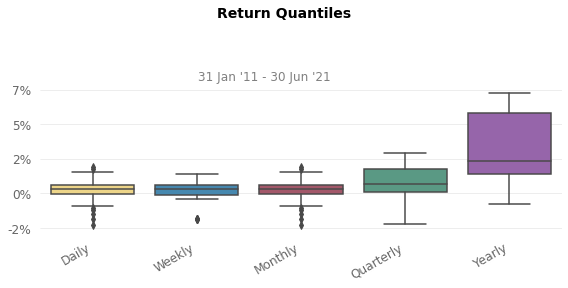

In [11]:
quantstats.reports.full(returns=month_rebal_strategy['strategy_return'], benchmark=month_rebal_strategy['benchmark_return'])

### Leverage Risk parity strategy
#### 50% leverage and check risk adjusted score

In [16]:
month_rebal_strategy.loc[:,'strategy_return']= 1.5 * month_rebal_strategy.loc[:,'strategy_return']

                           Strategy    Benchmark
-------------------------  ----------  -----------
Start Period               2011-01-31  2011-01-31
End Period                 2021-06-30  2021-06-30
Risk-Free Rate             0.0%        0.0%
Time in Market             100.0%      100.0%

Cumulative Return          83.47%      94.2%
CAGR﹪                     6.0%        6.58%

Sharpe                     6.37        3.41
Smart Sharpe               6.05        3.24
Sortino                    10.99       5.05
Smart Sortino              10.44       4.81
Sortino/√2                 7.77        3.57
Smart Sortino/√2           7.39        3.4
Omega                      2.85        2.85

Max Drawdown               -5.86%      -14.22%
Longest DD Days            397         609
Volatility (ann.)          19.4%       41.57%
R^2                        0.66        0.66
Calmar                     1.02        0.46
Skew                       -0.63       -0.91
Kurtosis                   1.71        4.3

None

,Start,Valley,End,Days,Max Drawdown,99% Max Drawdown
1,2015-06-30,2016-02-29,2016-07-31,397,-5.857286,-5.563944
2,2011-09-30,2011-10-31,2012-02-29,152,-4.611355,-2.132103
3,2020-04-30,2020-04-30,2020-06-30,61,-4.087041,-1.025152
4,2013-06-30,2013-07-31,2013-12-31,184,-3.521667,-2.512493
5,2016-11-30,2016-12-31,2017-02-28,90,-2.749287,-1.343207


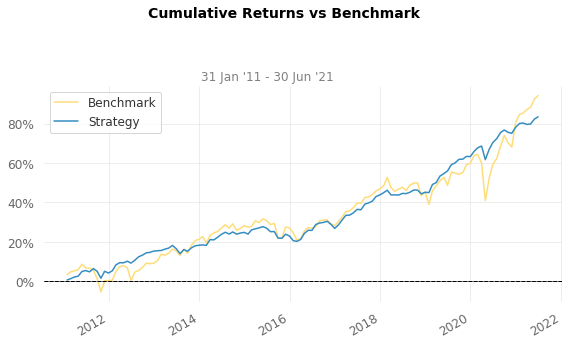

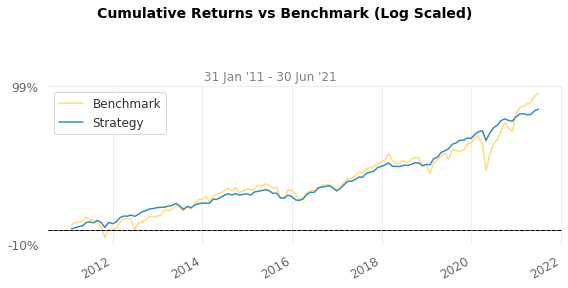

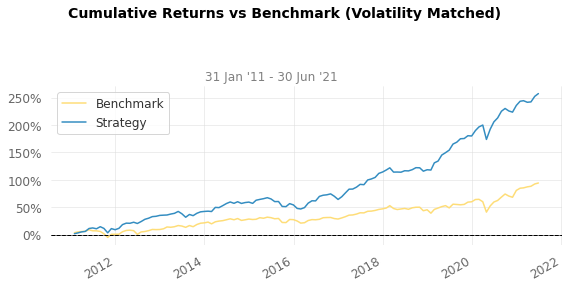

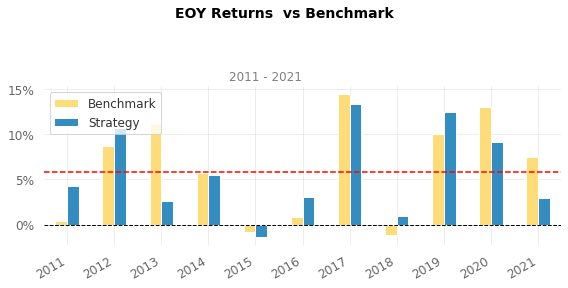

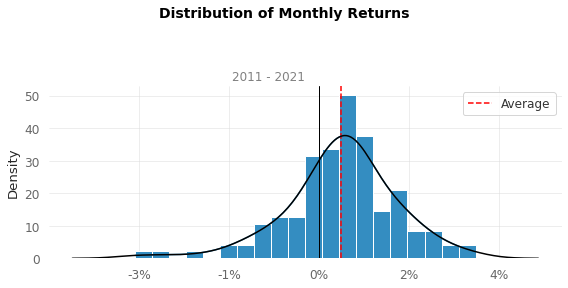

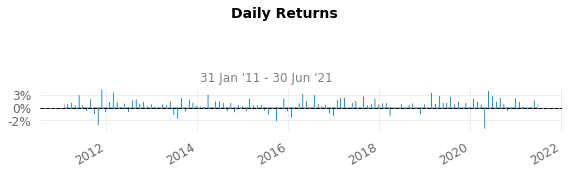

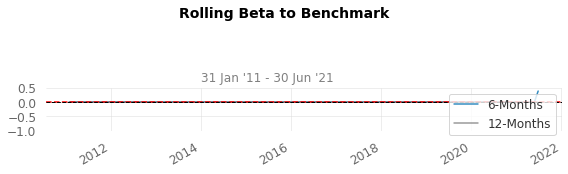

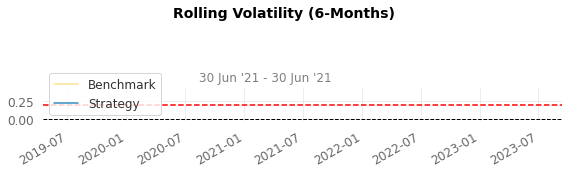

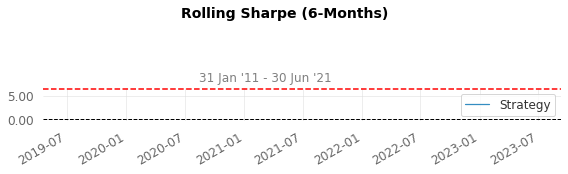

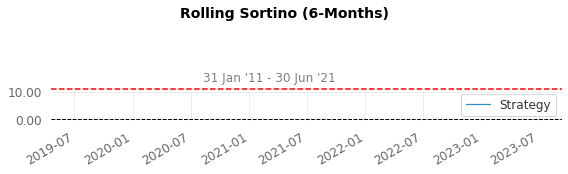

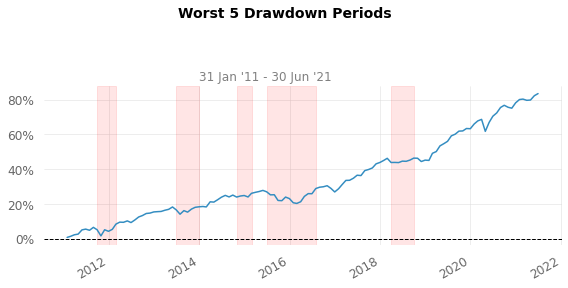

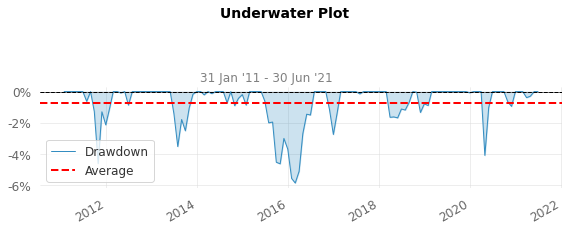

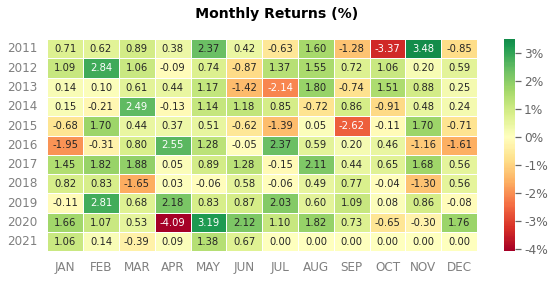

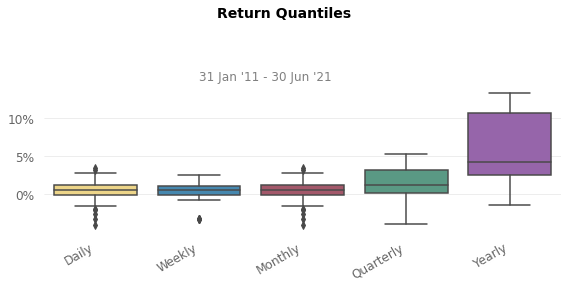

In [17]:
quantstats.reports.full(returns=month_rebal_strategy['strategy_return'], benchmark=month_rebal_strategy['benchmark_return'])